# MPCA, SVM, NN, Metrics (Accuracy, ROC, AUC)

In [1]:
import os;
import tensorflow as tf;
import numpy as np;
import matplotlib.pyplot as plt;
import sklearn;
from sklearn import svm;
from sklearn import metrics;
os.environ['KMP_DUPLICATE_LIB_OK']='True'; # for MAC

In [2]:
# function
def unfold(X, k):
    # X: p1,p2,n
    n= X.shape[0];
    p1 = X.shape[1];
    p2 = X.shape[2];
    if k == 0:
        X = np.transpose(X,(1,2,0));
        Xk = np.reshape(X, [p1,n * p2],order='F')
    else:
        X = np.transpose(X,(2,1,0));
        Xk = np.reshape(X, [p2, p1*n],order='F')
    return Xk;

In [3]:
# load data
imgX = 224;
imgY = 224;
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    #width_shift_range=0.05,
    #height_shift_range=0.15,
    #rotation_range=10,
    #zoom_range=0.1,
)
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "/Users/b5061/Desktop/Sinica/chest_xray/train",
    target_size=(imgX,imgY),
    batch_size=5216, # 5216
    class_mode="binary", # input --> if unsupervised training
    color_mode="grayscale",
    shuffle=True,
)
 
validation_generator = validation_datagen.flow_from_directory(
    "/Users/b5061/Desktop/Sinica/chest_xray/val",
    target_size=(imgX,imgY),
    class_mode="binary",
    color_mode="grayscale",
    shuffle=False,
    batch_size=16,
)
test_generator = test_datagen.flow_from_directory(
    "/Users/b5061/Desktop/Sinica/chest_xray/test",
    target_size=(imgX,imgY),
    class_mode="binary",
    color_mode="grayscale",
    shuffle=False,
    batch_size=624,
)
# num classes
num_classes = 2;
# X: 5216 x 224 x 224 x 1

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
q1 = 10;
q2 = 10;

In [5]:
# Training data
X,Y = train_generator.next();
X = np.reshape(X,[X.shape[0], X.shape[1], X.shape[2]]); # reshape to n x p1 x p2
print('size of X:')
print(X.shape);
n = X.shape[0];
p1 = X.shape[1];
p2 = X.shape[2];

size of X:
(5216, 224, 224)


In [6]:
# Testing data
Xtest, Ytest = test_generator.next();
m = Xtest.shape[0];
Xtest = np.reshape(Xtest, [m, p1, p2]);
print('size of Xtest:');
print(Xtest.shape);

size of Xtest:
(624, 224, 224)


In [7]:
# HOSVD
X1 = unfold(X,0); # p x nq; X_{(col)}
X2 = unfold(X,1); # p x nq; X_{(row)}
print('size of X(1) and X(2):')
print(X1.shape);
print(X2.shape);
U1, S1, V1 = np.linalg.svd(X1 @ X1.T); # size p x p matrix SVD
U2, S2, V2 = np.linalg.svd(X2 @ X2.T); # size q x q matrix SVD
A = U1[:,0:q1];
B = U2[:,0:q2];
print('size of A and B:')
print(A.shape);
print(B.shape);

size of X(1) and X(2):
(224, 1168384)
(224, 1168384)
size of A and B:
(224, 10)
(224, 10)


In [8]:
# GLRAM:
count = 3; # num of iterations
for i in range(count):
    # update A
    Bn = np.expand_dims(B,0) # --> [1,p2,q2]
    Bn = np.tile(Bn,[n,1,1]); # --> [n,p2,q2]
    XB = np.matmul(X,Bn); # --> [n,p1,q2]
    XB2 = unfold(XB,0); # --> [p1,n*q2]
    U1,S1,V1 = np.linalg.svd(XB2 @ XB2.T)
    A = U1[:,0:q1];
    
    # update B
    ATn = np.expand_dims(A.T,0) # --> [1,q1,p1]
    ATn = np.tile(ATn,[n,1,1]); # --> [n,q1,p1]
    AX = np.matmul(ATn,X); # --> [n,q1,p2]
    AX1 = unfold(AX,1); # --> [p2,n*q1]
    U2,S2,V2 = np.linalg.svd(AX1 @ AX1.T)
    B = U2[:,0:q2];
    
    # compute reconstruction error
    AATn = np.expand_dims(A @ A.T,0);
    AATn = np.tile(AATn,[n,1,1]);
    BBTn = np.expand_dims(B @ B.T,0);
    BBTn = np.tile(BBTn,[n,1,1]);
    X_ = AATn @ X @ BBTn;
    error = np.sum(np.sum(np.square(X-X_),axis=1),axis=1);
    print(np.mean(error));

253.14383
253.14319
253.14319


In [9]:
# Dimension reduction (Testing data & Training data)
An = np.expand_dims(A, 0); # --> [1,p1,q1]
An = np.tile(An, [n,1,1]); # --> [n,p1,q1]
AnT = np.transpose(An, (0,2,1)); # --> [n,q1,p1]
Bn = np.expand_dims(B,0); # --> [1,p1,q1]
Bn = np.tile(Bn, [n,1,1]); # --> [n,p1,q1]
Xlow = AnT @ X @ Bn; # --> [n,q1,q2]
# 
Am = np.expand_dims(A, 0); # --> [1,p1,q1]
Am = np.tile(Am, [m,1,1]); # --> [n,p1,q1]
AmT = np.transpose(Am, (0,2,1)); # --> [n,q1,p1]
Bm = np.expand_dims(B,0); # --> [1,p1,q1]
Bm = np.tile(Bm, [m,1,1]); # --> [n,p1,q1]
Xtest_low = AmT @ Xtest @ Bm; # --> [n,q1,q2]
#
print('size of Xlow and Xtest_low:');
print(Xlow.shape);
print(Xtest_low.shape);

size of Xlow and Xtest_low:
(5216, 10, 10)
(624, 10, 10)


In [11]:
# Reconstruction (Testing data)
AATm = np.expand_dims(A @ A.T, 0);
BBTm = np.expand_dims(B @ B.T, 0);
AATm = np.tile(AATm,[m,1,1]);
BBTm = np.tile(BBTm,[m,1,1]);
Xtest_reconst = AATm @ Xtest @ BBTm;

### SVM classifier

In [13]:
Xlow_vec = np.reshape(Xlow, [n,q1*q2], order='F');
Xtest_low_vec = np.reshape(Xtest_low, [m, q1*q2], order='F');

In [14]:
mysvm = svm.SVC(kernel='linear', C=1);  
mysvm.fit(Xlow_vec, Y);
Ytest_predict = mysvm.predict(Xtest_low_vec); # prediction
svm_accuracy = np.sum(Ytest == Ytest_predict) / m;
print(svm_accuracy);

mysvm2 = svm.SVC(kernel='rbf', C=1); # gamma = default for 'rbf'
mysvm2.fit(Xlow_vec, Y);
Ytest_predict = mysvm2.predict(Xtest_low_vec); # prediction
svm_accuracy = np.sum(Ytest == Ytest_predict) / m;
print(svm_accuracy);

0.7435897435897436
0.7644230769230769


In [15]:
# logistic via NN
model = tf.keras.Sequential()
model.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones'));
model.add(tf.keras.layers.Dense(1, activation='sigmoid', input_shape=(q1*q2,)))
model.compile(loss='binary_crossentropy',optimizer='RMSprop',metrics=['accuracy'])
history = model.fit(Xlow_vec, Y, batch_size=250, epochs=50, verbose=1, validation_data=(Xtest_low_vec, Ytest))

Epoch 1/50
21/21 [==============================] - 0s 9ms/step - loss: 0.7183 - accuracy: 0.5993 - val_loss: 1.1602 - val_accuracy: 0.6410
Epoch 2/50
21/21 [==============================] - 0s 2ms/step - loss: 0.5378 - accuracy: 0.7462 - val_loss: 0.7999 - val_accuracy: 0.6506
Epoch 3/50
21/21 [==============================] - 0s 2ms/step - loss: 0.4294 - accuracy: 0.8236 - val_loss: 0.6725 - val_accuracy: 0.6875
Epoch 4/50
21/21 [==============================] - 0s 2ms/step - loss: 0.3528 - accuracy: 0.8691 - val_loss: 0.6218 - val_accuracy: 0.6987
Epoch 5/50
21/21 [==============================] - 0s 2ms/step - loss: 0.2982 - accuracy: 0.8949 - val_loss: 0.5995 - val_accuracy: 0.7099
Epoch 6/50
21/21 [==============================] - 0s 2ms/step - loss: 0.2587 - accuracy: 0.9120 - val_loss: 0.5947 - val_accuracy: 0.7212
Epoch 7/50
21/21 [==============================] - 0s 2ms/step - loss: 0.2301 - accuracy: 0.9218 - val_loss: 0.5946 - val_accuracy: 0.7260
Epoch 8/50
21/21 [==

### Neural Network classifier

In [17]:
#y_train = tf.keras.utils.to_categorical(Y, num_classes)
#y_test = tf.keras.utils.to_categorical(Ytest, num_classes)

In [18]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(8, activation='relu', input_shape=(q1*q2,)))
model.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones'));
model.add(tf.keras.layers.Dense(4, activation='relu'))
model.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones'));
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='RMSprop',metrics=['accuracy', tf.keras.metrics.AUC(num_thresholds=200, curve='ROC', summation_method='interpolation')]); # or 'AUC' also works.
history = model.fit(Xlow_vec, Y, batch_size=250, epochs=50, verbose=1, validation_data=(Xtest_low_vec, Ytest))

Epoch 1/50
21/21 [==============================] - 0s 13ms/step - loss: 0.6948 - accuracy: 0.5957 - auc: 0.7460 - val_loss: 1.1820 - val_accuracy: 0.6218 - val_auc: 0.5932
Epoch 2/50
21/21 [==============================] - 0s 2ms/step - loss: 0.5527 - accuracy: 0.6969 - auc: 0.8758 - val_loss: 1.0201 - val_accuracy: 0.6218 - val_auc: 0.6081
Epoch 3/50
21/21 [==============================] - 0s 2ms/step - loss: 0.4799 - accuracy: 0.7627 - auc: 0.9253 - val_loss: 0.9077 - val_accuracy: 0.6250 - val_auc: 0.6513
Epoch 4/50
21/21 [==============================] - 0s 2ms/step - loss: 0.4249 - accuracy: 0.8108 - auc: 0.9526 - val_loss: 0.7804 - val_accuracy: 0.6266 - val_auc: 0.7598
Epoch 5/50
21/21 [==============================] - 0s 2ms/step - loss: 0.3775 - accuracy: 0.8505 - auc: 0.9681 - val_loss: 0.7447 - val_accuracy: 0.6330 - val_auc: 0.8198
Epoch 6/50
21/21 [==============================] - 0s 2ms/step - loss: 0.3370 - accuracy: 0.8748 - auc: 0.9768 - val_loss: 0.7682 - val_ac

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 808       
_________________________________________________________________
batch_normalization_1 (Batch (None, 8)                 32        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
batch_normalization_2 (Batch (None, 4)                 16        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 897
Trainable params: 873
Non-trainable params: 24
_________________________________________________________________


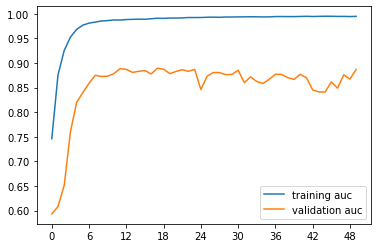

In [20]:
# Check AUC
import matplotlib.ticker as ticker;
auc_training = history.history['auc'];
auc_testing = history.history['val_auc'];
plt.plot(auc_training, label='training auc');
plt.plot(auc_testing, label='validation auc');
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True));
plt.legend();

In [21]:
# draw ROC
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions);
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs);
    plt.xlabel('False positives [%]');
    plt.ylabel('True positives [%]');
    plt.xlim([-0.5,100.5]);
    plt.ylim([-0.5,100.5]);
    plt.grid(True);
    ax = plt.gca();
    ax.set_aspect('equal')

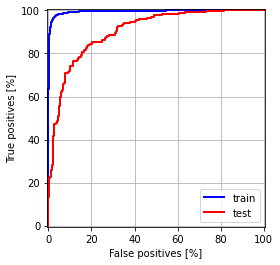

In [25]:
# predict
predictions_train = model.call(tf.Variable(Xlow_vec));
predictions_test = model.call(tf.Variable(Xtest_low_vec));

# plot
plot_roc('train', Y, predictions_train ,color='blue');
plot_roc('test', Ytest, predictions_test ,color='red');
plt.legend(loc='lower right');